In [1]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import cv2
import random
from PIL import Image
import time
from tqdm import tqdm

# Import models and dataset and utils
from SIDD_Dataset import SIDD_Dataset

random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

noisy_img_array = np.load('./data/noisy_img_array.npy', allow_pickle=True)
gt_img_array = np.load('./data/gt_img_array.npy', allow_pickle=True)

# Normalize images to [0, 1] range
noisy_img_array = noisy_img_array.astype(np.float32) / 255.0
gt_img_array = gt_img_array.astype(np.float32) / 255.0

print(noisy_img_array.shape)
print(gt_img_array.shape)

print(np.max(noisy_img_array), np.min(noisy_img_array))
print(np.max(gt_img_array), np.min(gt_img_array))

(160, 1024, 1024, 3)
(160, 1024, 1024, 3)
1.0 0.0
1.0 0.0


## 이미지 캐싱

/Users/byungwanlim/Workspace/N2N_CA2/SIDD_Dataset.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(cache_file)
Clipping input data to the valid r

=== SIDD_Dataset 초기화 (img_size=224) ===
캐시 파일을 로드합니다: ./dataset_cache/sidd_processed_224.pt
캐시 로드 완료. 소요 시간: 0.03초
데이터 크기: 160 샘플, 이미지 크기: 112x112


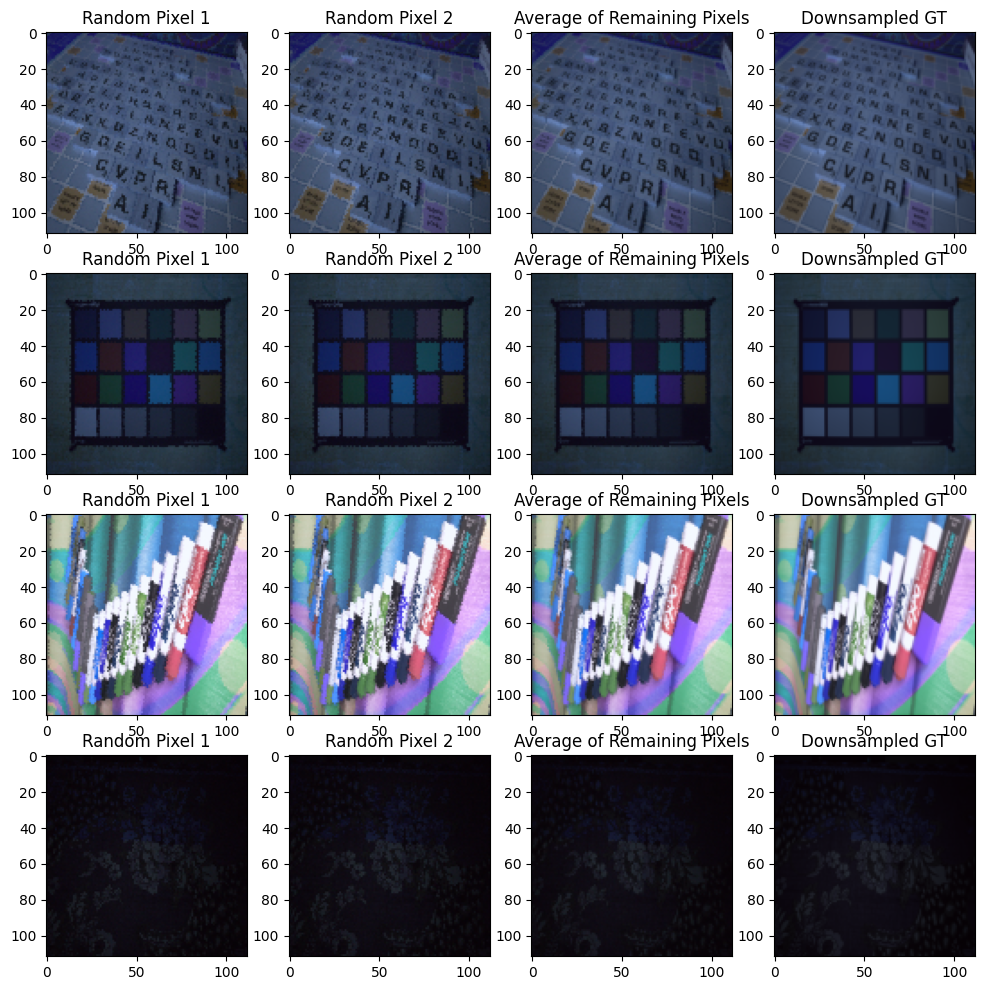

In [2]:
img_size = 224
batch_size = 32

# Prepare dataset and dataloader
dataset = SIDD_Dataset(noisy_img_array, gt_img_array, img_size=img_size)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Get one batch of data
data_iter = iter(dataloader)
img1, img2, img3, downsampled_gt = next(data_iter)

# Display the images in the batch
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    axes[i, 0].imshow(img1[i].permute(1, 2, 0).numpy())
    axes[i, 0].set_title('Random Pixel 1')
    axes[i, 1].imshow(img2[i].permute(1, 2, 0).numpy())
    axes[i, 1].set_title('Random Pixel 2')
    axes[i, 2].imshow(img3[i].permute(1, 2, 0).numpy())
    axes[i, 2].set_title('Average of Remaining Pixels')
    axes[i, 3].imshow(downsampled_gt[i].permute(1, 2, 0).numpy())
    axes[i, 3].set_title('Downsampled GT')
plt.show()

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from models.DnCNN import DnCNN
from models.DnCNN_CA import DnCNN_CA
from SIDD_Dataset import SIDD_Dataset
from train import train
from utils import visualize_input_target_output, measure_model_complexity


def main(num_epochs=50, batch_size=16, learning_rate=0.001, img_size=512, early_stop=10, ca=None):
    """
    학습을 수행하는 메인 함수
    
    Args:
        num_epochs: 훈련 에폭 수
        batch_size: 배치 크기
        learning_rate: 학습률
        noise_level: 노이즈 수준 (모델 저장 파일명에 사용)
        img_size: 이미지 크기
        ca: None 또는 'ca' (채널 어텐션 사용 여부)
    """
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 중인 디바이스: {device}")
    
    # 체크포인트 디렉토리 생성
    os.makedirs('./checkpoints', exist_ok=True)
    
    # 데이터 로드
    print("SIDD 데이터셋 로드 중...")
    try:
        # 데이터셋 경로 설정 (실제 경로로 수정 필요)
        data_path = 'data'
        
        # 데이터 로드 (실제 데이터 로드 코드로 대체 필요)
        noisy_data = np.load(f'{data_path}/noisy_img_array.npy', mmap_mode='r')
        gt_data = np.load(f'{data_path}/gt_img_array.npy', mmap_mode='r')
        noisy_data = noisy_data.astype(np.float32) / 255.0
        gt_data = gt_data.astype(np.float32) / 255.0
        
        print(f"데이터 로드 완료: noisy shape {noisy_data.shape}, gt shape {gt_data.shape}")
        
        # 데이터셋 생성
        dataset = SIDD_Dataset(noisy_data, gt_data, img_size=img_size)
        
        # 학습/검증 분할
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
        
        # 데이터로더 생성
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)
        
        print(f"학습 샘플 수: {len(train_dataset)}, 검증 샘플 수: {len(val_dataset)}")
        
    except Exception as e:
        print(f"데이터 로드 중 오류 발생: {e}")
        return
    
    # 모델 초기화
    print("모델 초기화 중...")
    if ca == 'ca':
        model = DnCNN_CA(in_channels=6, out_channels=3)
        print("채널 어텐션이 포함된 DnCNN 모델 생성됨")
    else:
        model = DnCNN(in_channels=6, out_channels=3)
        print("기본 DnCNN 모델 생성됨")
    
    # 모델 GFLOPs 계산
    # flops, params = measure_model_complexity(model, img_size=img_size, device=device)
    # flops, params = measure_model_complexity(model, img_size=img_size, device=device)
    # print(f"모델 GFLOPs: {flops / 1e9:.2f} GFLOPs")
    params = sum(p.numel() for p in model.parameters())
    print(f"모델 총 파라미터: {params:,}")
    
    # 옵티마이저 및 손실 함수 설정
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # 학습 시작
    print(f"학습 시작 - {num_epochs} 에폭")
    train_losses, val_losses = train(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        num_epochs=num_epochs,
        device=device,
        early_stop=early_stop,
        ca=ca,
    )
    
    # 최종 모델 저장
    if ca is not None:
        model_name = f'final_dncnn_model_{ca}.pth'
    else:
        model_name = f'final_dncnn_model.pth'
    model_path = os.path.join('./checkpoints', model_name)
    torch.save(model.state_dict(), model_path)
    print(f"최종 모델 저장 완료: {model_path}")
    
    # 최종 결과 시각화
    print("최종 결과 시각화 중...")
    model.eval()
    visualize_input_target_output(model, val_loader, device, num_samples=2)
    
    print("학습 및 평가 완료!")
    return model, train_losses, val_losses

In [ ]:
num_epochs = 1  # 학습 에폭 수
batch_size = 4   # 배치 크기
learning_rate = 0.0001  # 학습률
early_stop = 15

img_size = 224  # 이미지 크기

사용 중인 디바이스: cpu
SIDD 데이터셋 로드 중...
데이터 로드 완료: noisy shape (160, 1024, 1024, 3), gt shape (160, 1024, 1024, 3)
=== SIDD_Dataset 초기화 (img_size=224) ===
캐시 파일을 로드합니다: ./dataset_cache/sidd_processed_224.pt
캐시 로드 완료. 소요 시간: 0.01초
데이터 크기: 160 샘플, 이미지 크기: 112x112
학습 샘플 수: 128, 검증 샘플 수: 32
모델 초기화 중...
기본 DnCNN 모델 생성됨
모델 총 파라미터: 560,131
학습 시작 - 1 에폭


Epoch 1/1 [Val]: 100%|██████████| 8/8 [00:01<00:00,  4.33it/s]


Epoch 1/1 - Train Loss: 0.0882, Val Loss: 0.0445, Val PSNR: 16.65dB
모델 저장됨 (Val Loss: 0.0445)


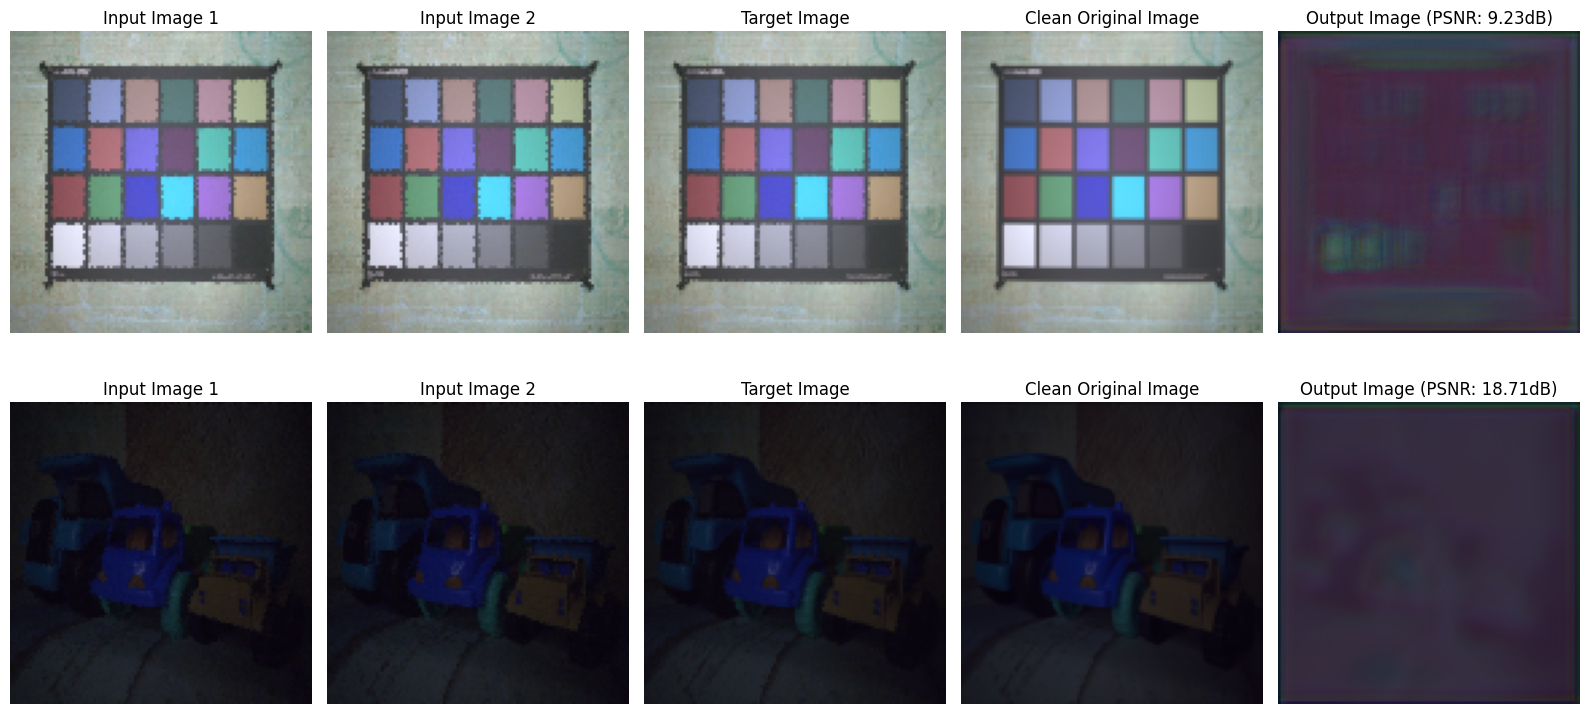

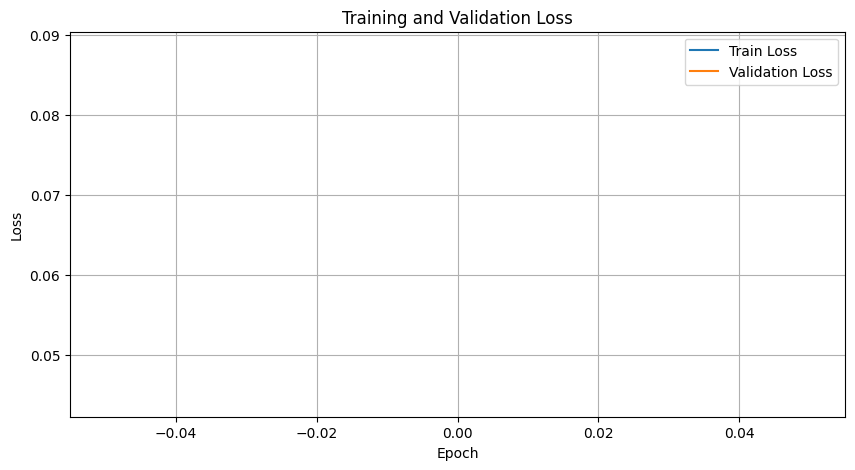

최종 모델 저장 완료: ./checkpoints/final_dncnn_model.pth
최종 결과 시각화 중...


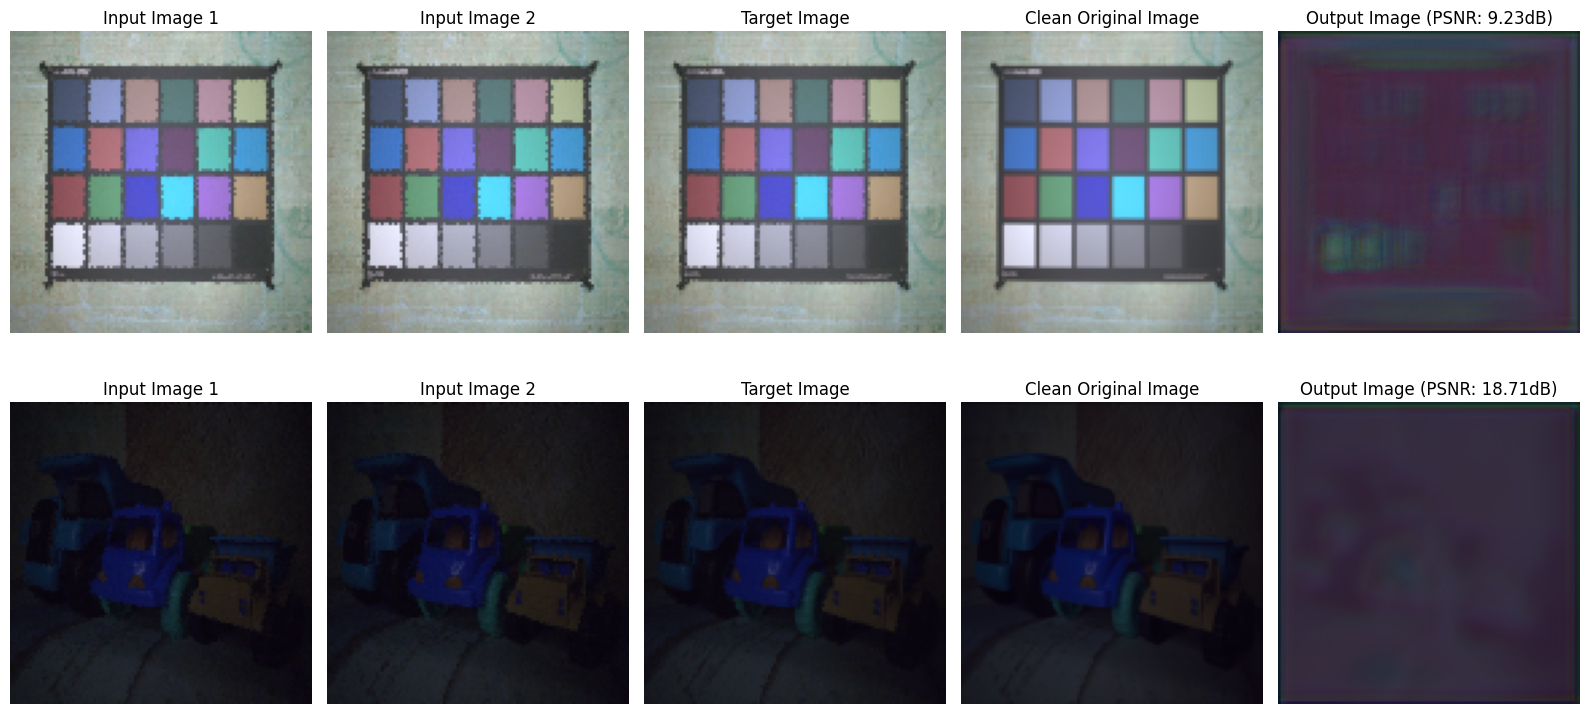

학습 및 평가 완료!


In [ ]:

# 실행 코드
if __name__ == "__main__":
    # 하이퍼파라미터 설정
    num_epochs = num_epochs  # 학습 에폭 수
    batch_size = batch_size   # 배치 크기
    learning_rate = learning_rate  # 학습률
    img_size = img_size  # 이미지 크기
    ca = None  # 'ca'로 설정하면 채널 어텐션 모델 사용
    early_stop = early_stop
    
    # 학습 실행
    model, train_losses, val_losses = main(
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        img_size=img_size,
        early_stop=early_stop,
        ca=ca
    )

In [6]:
import torch

torch.cuda.empty_cache()
print("GPU memory cleared.")

GPU memory cleared.


사용 중인 디바이스: cpu
SIDD 데이터셋 로드 중...
데이터 로드 완료: noisy shape (160, 1024, 1024, 3), gt shape (160, 1024, 1024, 3)
=== SIDD_Dataset 초기화 (img_size=224) ===
캐시 파일을 로드합니다: ./dataset_cache/sidd_processed_224.pt
캐시 로드 완료. 소요 시간: 0.03초
데이터 크기: 160 샘플, 이미지 크기: 112x112
학습 샘플 수: 128, 검증 샘플 수: 32
모델 초기화 중...
채널 어텐션이 포함된 DnCNN 모델 생성됨
모델 총 파라미터: 491,427
학습 시작 - 1 에폭


Epoch 1/1 [Val]: 100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


Epoch 1/1 - Train Loss: 0.0664, Val Loss: 0.0554, Val PSNR: 15.79dB
모델 저장됨 (Val Loss: 0.0554)


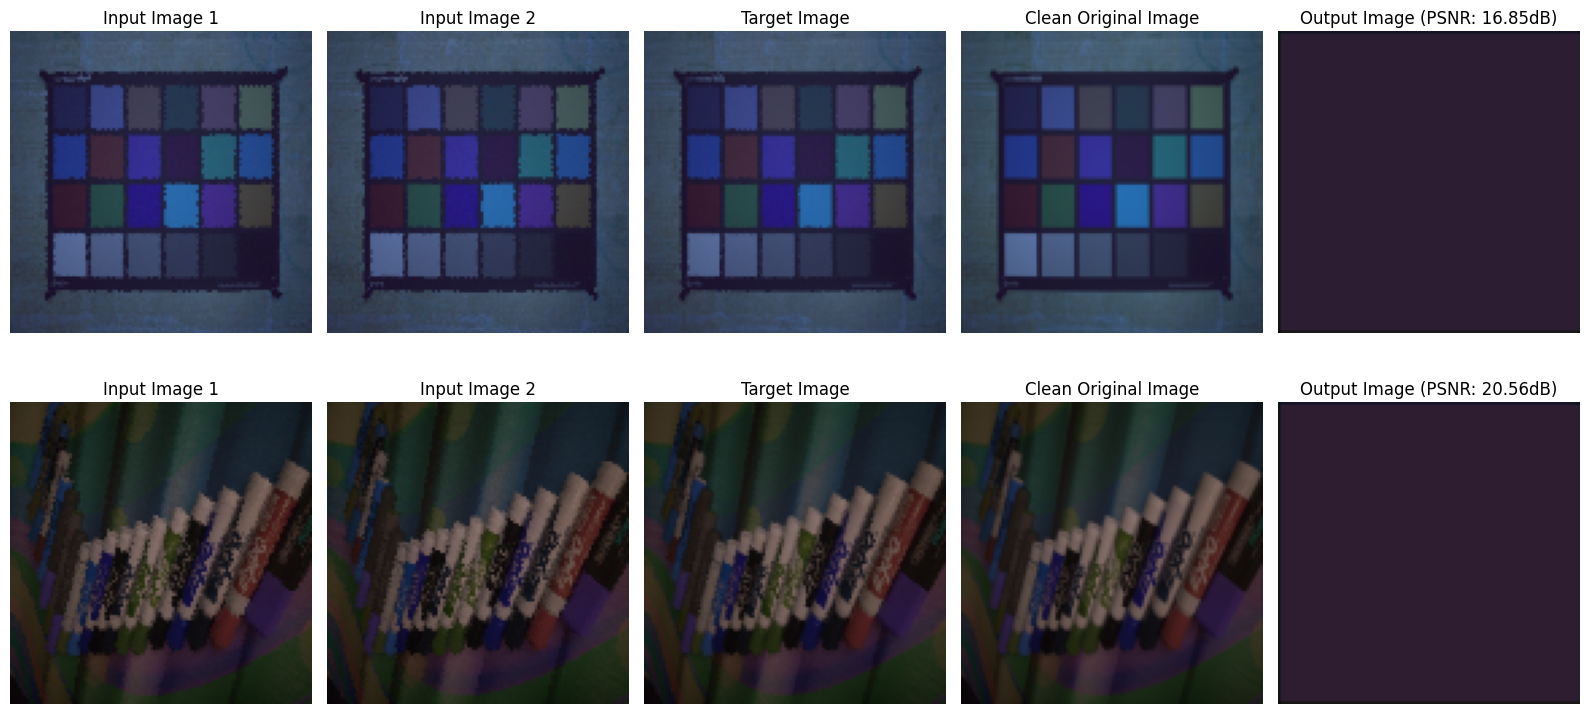

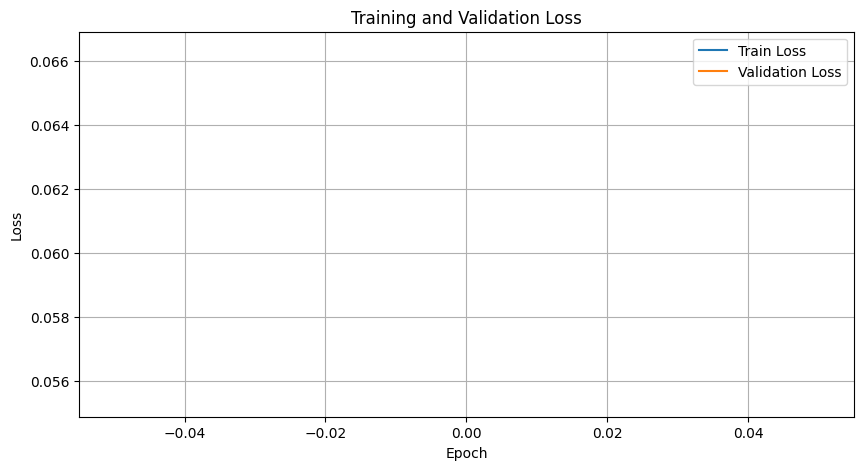

최종 모델 저장 완료: ./checkpoints/final_dncnn_model_ca.pth
최종 결과 시각화 중...


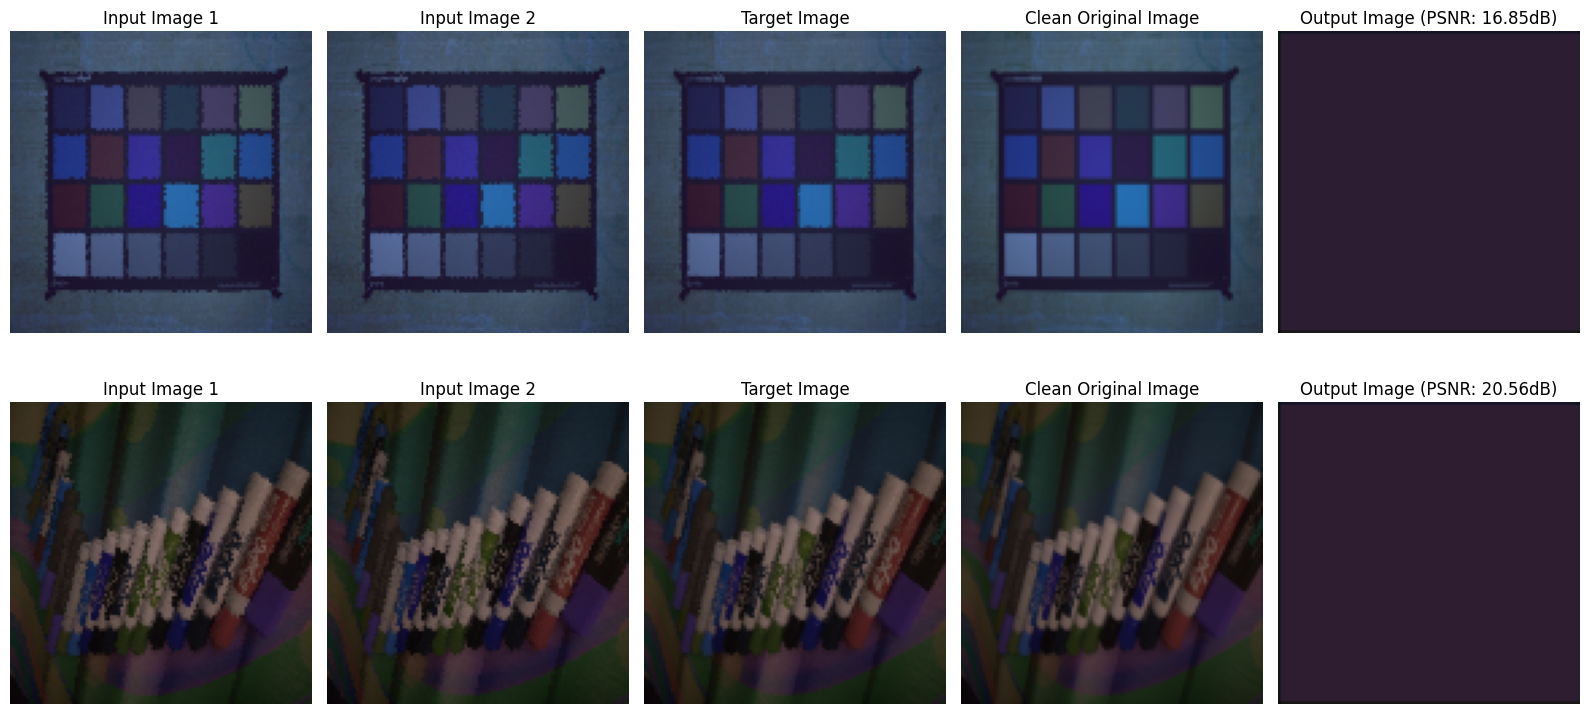

학습 및 평가 완료!


In [ ]:
# 실행 코드
if __name__ == "__main__":
    # 하이퍼파라미터 설정
    num_epochs = num_epochs  # 학습 에폭 수
    batch_size = batch_size   # 배치 크기\
    learning_rate = learning_rate  # 학습률
    img_size = img_size  # 이미지 크기
    ca = 'ca'  # 'ca'로 설정하면 채널 어텐션 모델 사용
    early_stop = early_stop
    
    # 학습 실행
    model, train_losses, val_losses = main(
        num_epochs=num_epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        img_size=img_size,
        ca=ca
    )

사용 중인 디바이스: cpu


/Users/byungwanlim/Workspace/N2N_CA2/SIDD_Dataset.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cache_data = torch.load(cache_file)
/Users/byungwanlim/Workspace/N2N_C

=== SIDD_Dataset 초기화 (img_size=224) ===
캐시 파일을 로드합니다: ./dataset_cache/sidd_processed_224.pt
캐시 로드 완료. 소요 시간: 0.01초
데이터 크기: 160 샘플, 이미지 크기: 112x112
DnCNN 모델 평가 중...
./checkpoints/final_dncnn_model.pth 모델 불러오기 완료


모델 평가 중: 100%|██████████| 8/8 [00:01<00:00,  4.25it/s]


DnCNN 평균 PSNR: 17.49dB
DnCNN_ca 모델 평가 중...
./checkpoints/final_dncnn_model_ca.pth 모델 불러오기 완료


모델 평가 중: 100%|██████████| 8/8 [00:14<00:00,  1.86s/it]
/Users/byungwanlim/Workspace/N2N_CA2/compare.py:162: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.savefig('./checkpoints/psnr_comparison.png', dpi=300)
/Users/byungwanlim/Workspace/N2N_CA2/compare.py:162: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.savefig('./checkpoints/psnr_comparison.png', dpi=300)
/Users/byungwanlim/Workspace/N2N_CA2/compare.py:162: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.savefig('./checkpoints/psnr_comparison.png', dpi=300)
/Users/byungwanlim/Workspace/N2N_CA2/compare.py:162: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.savefig('./checkpoints/psnr_comparison.png', dpi=300)
/Users/byungwanlim/Workspace/N2N_CA2/compare.py:162: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  plt.savefig('

DnCNN_ca 평균 PSNR: 16.69dB


/Users/byungwanlim/miniconda3/envs/UM2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/byungwanlim/miniconda3/envs/UM2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/byungwanlim/miniconda3/envs/UM2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/byungwanlim/miniconda3/envs/UM2/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/byungwanlim/miniconda3/envs/UM2/lib/python3.12/site-packages/IPython/core/pylabtools.

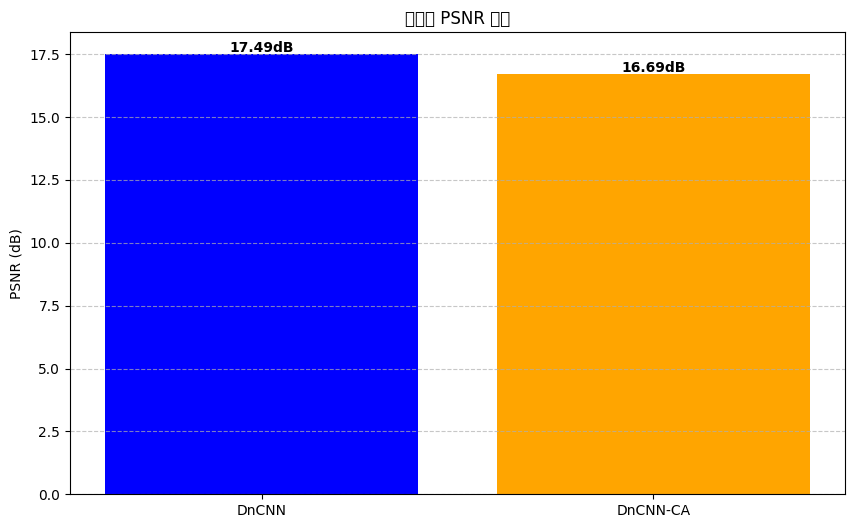

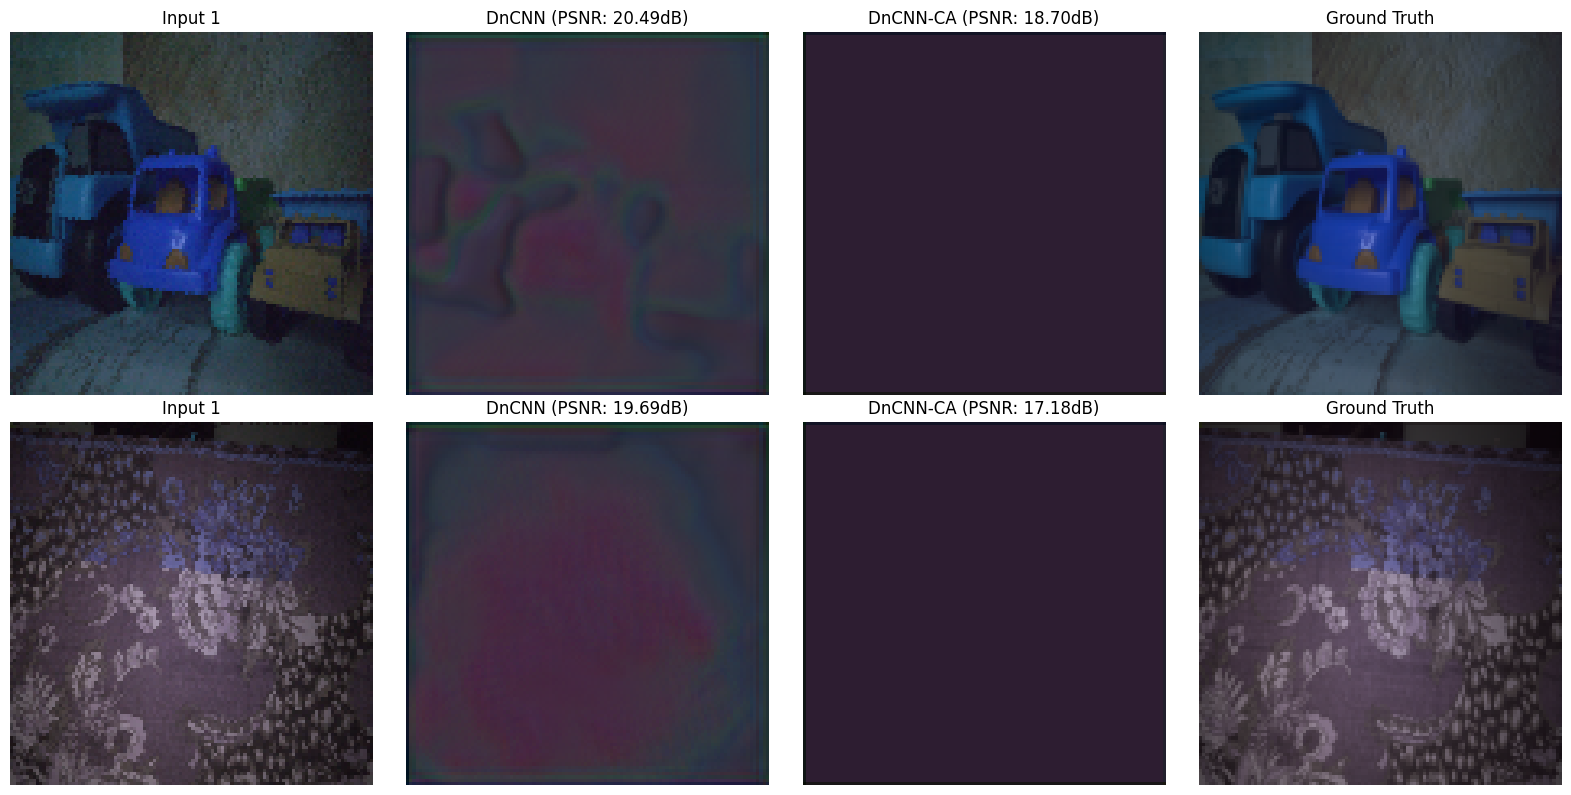

In [1]:
from compare import run_evaluation

img_size = 224
batch_size = 4
# 테스트 실행
run_evaluation(img_size=img_size, batch_size=batch_size)
